# YouTube's Data Analysts

### Importing relevant libraries

In [1]:
from googleapiclient.discovery import build
import pandas as pd
import googleapiclient.discovery
from IPython.display import JSON
import itertools

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sb
import imageio
import isodate

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### Extracting data from youtube API

In [2]:
api_key = ['']


#### Some channels which i chose so visualize

In [3]:
channel_names = [
    "Alex The Analyst",
    "Corey Schafer",
    "Ken Jee",
    "Mo Chen",
    "Luke Barousse",
    "Data Professor",
    "Tech With Tim",
    "Data Science Jay",
    "Nicholas Renotte",
    "StatQuest with Josh Starmer"
]

youtube = build('youtube', 'v3', developerKey=api_key)

channel_ids = {}

for channel_name in channel_names:
    request = youtube.search().list(
        part='snippet',
        q=channel_name,
        type='channel',
        maxResults=1
    )
    response = request.execute()

    if response['items']:
        channel_id = response['items'][0]['id']['channelId']
        channel_ids[channel_name] = channel_id
        print(f"Channel: {channel_name} | ID: {channel_id}")
    else:
        print(f"Channel: {channel_name} not found.")

print(channel_ids)


Channel: Alex The Analyst | ID: UC7cs8q-gJRlGwj4A8OmCmXg
Channel: Corey Schafer | ID: UCCezIgC97PvUuR4_gbFUs5g
Channel: Ken Jee | ID: UCiT9RITQ9PW6BhXK0y2jaeg
Channel: Mo Chen | ID: UCDybamfye5An6p-j1t2YMsg
Channel: Luke Barousse | ID: UCLLw7jmFsvfIVaUFsLs8mlQ
Channel: Data Professor | ID: UCV8e2g4IWQqK71bbzGDEI4Q
Channel: Tech With Tim | ID: UC4JX40jDee_tINbkjycV4Sg
Channel: Data Science Jay | ID: UCcQx1UnmorvmSEZef4X7-6g
Channel: Nicholas Renotte | ID: UCHXa4OpASJEwrHrLeIzw7Yg
Channel: StatQuest with Josh Starmer | ID: UCtYLUTtgS3k1Fg4y5tAhLbw
{'Alex The Analyst': 'UC7cs8q-gJRlGwj4A8OmCmXg', 'Corey Schafer': 'UCCezIgC97PvUuR4_gbFUs5g', 'Ken Jee': 'UCiT9RITQ9PW6BhXK0y2jaeg', 'Mo Chen': 'UCDybamfye5An6p-j1t2YMsg', 'Luke Barousse': 'UCLLw7jmFsvfIVaUFsLs8mlQ', 'Data Professor': 'UCV8e2g4IWQqK71bbzGDEI4Q', 'Tech With Tim': 'UC4JX40jDee_tINbkjycV4Sg', 'Data Science Jay': 'UCcQx1UnmorvmSEZef4X7-6g', 'Nicholas Renotte': 'UCHXa4OpASJEwrHrLeIzw7Yg', 'StatQuest with Josh Starmer': 'UCtYLUTtgS3k

In [4]:
youtube_channel_ids = [
    "UC7cs8q-gJRlGwj4A8OmCmXg",
    "UCCezIgC97PvUuR4_gbFUs5g",
    "UCiT9RITQ9PW6BhXK0y2jaeg",
    "UCDybamfye5An6p-j1t2YMsg",
    "UCLLw7jmFsvfIVaUFsLs8mlQ",
    "UCV8e2g4IWQqK71bbzGDEI4Q",
    "UC4JX40jDee_tINbkjycV4Sg",
    "UCcQx1UnmorvmSEZef4X7-6g",
    "UCHXa4OpASJEwrHrLeIzw7Yg",
    "UCtYLUTtgS3k1Fg4y5tAhLbw"
]

print(youtube_channel_ids)

['UC7cs8q-gJRlGwj4A8OmCmXg', 'UCCezIgC97PvUuR4_gbFUs5g', 'UCiT9RITQ9PW6BhXK0y2jaeg', 'UCDybamfye5An6p-j1t2YMsg', 'UCLLw7jmFsvfIVaUFsLs8mlQ', 'UCV8e2g4IWQqK71bbzGDEI4Q', 'UC4JX40jDee_tINbkjycV4Sg', 'UCcQx1UnmorvmSEZef4X7-6g', 'UCHXa4OpASJEwrHrLeIzw7Yg', 'UCtYLUTtgS3k1Fg4y5tAhLbw']


In [5]:
api_service_name = "youtube"
api_version = "v3"
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=api_key)

#### Extract Channel stats from selected channels

In [6]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()
    
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'publishDate': item['snippet']['publishedAt'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    all_data = pd.DataFrame(all_data)

    return(all_data)

#### Get video ID's from all the channels

In [7]:
def get_videos_ids(youtube, playlist_id):
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId= playlist_id,
        maxResults = 50
    )
    
    response = request.execute()
    
    for item in response['items']:
        data = {
                'videoId': item['contentDetails']['videoId']
               }
        video_ids.append(data)
    
    next_page_token = response.get('nextPageToken')  
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId= playlist_id,
            maxResults = 50,
            pageToken = next_page_token
            )
        response = request.execute()

        for item in response['items']:
            data = {
                    'videoId': item['contentDetails']['videoId']
               }
            video_ids.append(data)
        next_page_token = response.get('nextPageToken')
        
    return video_ids

#### Extract video details like Channeltitle, video title, description etc.

In [8]:
def get_video_details(youtube, video_ids):
    all_video_info = []
    for i in range(0,len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id= ','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            # create dictionary of stats I want to keep
            stats_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                          'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                          'contentDetails': ['duration', 'definition', 'caption']
                        }
            
            # empty dictionary to keep track of keys and values
            video_info = {}
            video_info['video_id'] = video['id']
            
            # extract values and append them into empty dictionary
            for k in stats_keep.keys():
                for v in stats_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
        video_df = pd.DataFrame(all_video_info)
    return video_df

#### Extract comments from all vidoes

In [9]:
def get_videos_comments(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
            # help https://developers.google.com/youtube/v3/docs/commentThreads?hl=en_US#snippet.topLevelComment
            video_comments = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] 
                              for comment in response['items'][0:10]]
            video_comments_info = {'video_id': video_id, 'comments': video_comments}
            all_comments.append(video_comments_info)
        except:
            pass 
            
    all_comments_df = pd.DataFrame(all_comments)
    return all_comments_df
        

#### Extract Channel Stats

In [10]:
channel_stats = get_channel_stats(youtube, youtube_channel_ids)
channel_stats

,channelName,publishDate,subscribers,views,totalVideos,playlistId
0,Data Professor,2019-08-17T15:59:56Z,200000,7164373,353,UUV8e2g4IWQqK71bbzGDEI4Q
1,Ken Jee,2014-02-28T14:58:24Z,266000,9310177,288,UUiT9RITQ9PW6BhXK0y2jaeg
2,Nicholas Renotte,2019-01-26T22:31:46Z,295000,20598464,308,UUHXa4OpASJEwrHrLeIzw7Yg
3,StatQuest with Josh Starmer,2011-05-24T01:52:48Z,1340000,74853965,285,UUtYLUTtgS3k1Fg4y5tAhLbw
4,Corey Schafer,2006-05-31T22:49:22Z,1410000,100463947,239,UUCezIgC97PvUuR4_gbFUs5g
5,Mo Chen,2022-12-25T20:25:38.187653Z,149000,5652126,215,UUDybamfye5An6p-j1t2YMsg
6,Alex The Analyst,2020-01-08T05:04:24.970712Z,974000,45315966,345,UU7cs8q-gJRlGwj4A8OmCmXg
7,Tech With Tim,2014-04-23T01:57:10Z,1670000,163598504,1316,UU4JX40jDee_tINbkjycV4Sg
8,Luke Barousse,2020-08-03T09:02:41.213077Z,498000,24871778,163,UULLw7jmFsvfIVaUFsLs8mlQ
9,Jay Feng,2019-11-19T19:16:30.516571Z,52100,3491944,420,UUcQx1UnmorvmSEZef4X7-6g


#### Extract video stats for all channels

In [11]:
playlist_ids = list(channel_stats.playlistId.unique())
video_ids_list = []

for playlist_id in playlist_ids:
    video_ids = get_videos_ids(youtube, playlist_id)
    video_ids_list.append(video_ids)

#### Group all the lists together

In [12]:
video_ids_list_clean= list(itertools.chain(*video_ids_list))
video_ids_list_clean = [d['videoId'] for d in video_ids_list_clean]

In [13]:
video_ids = video_ids_list_clean
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,bUr-Y0969V4,Data Professor,From DNA to UI: Connecting the Dots between Th...,"In this video, I had the honor of delivering ...",None,2024-12-30T18:29:34Z,2030,76,None,17,PT25M37S,hd,false
1,KYfce1X5CXw,Data Professor,Code Your Own Multilingual AI in Python that s...,"In this tutorial, you'll learn how to build a ...",None,2024-12-10T01:05:00Z,1160,49,None,6,PT10M4S,hd,false
2,qShyjPKj8BY,Data Professor,Bioinformatics Project from Scratch PART 1 - C...,"In this video, you'll learn how to collect dat...",None,2024-11-28T15:00:54Z,2631,138,None,33,PT8M8S,hd,false
3,PytsxNfR8GI,Data Professor,Using Google Colab for Data Science and AI,"In this video, I'll help you get started with ...",None,2024-11-13T04:22:43Z,2814,110,None,11,PT23M7S,hd,false
4,RWBSd4Vh-90,Data Professor,Building a YouTube AI assistant for content cr...,"In this video, we'll build a YouTube AI assist...",None,2024-10-27T22:58:54Z,1301,55,None,8,PT9M55S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,GS8ZlcNO4ig,Jay Feng,"Election Hacking with Tyler, Data scientist at...",How possible is it to swing an election? Today...,None,2020-04-28T13:00:15Z,427,12,None,1,PT55M18S,hd,false
3935,sdBWA9MvgYI,Jay Feng,The Facebook Data Science Interview Questions,The Facebook data scientist job role is one of...,"[Data Scientist Interview, data science, data ...",2020-04-07T07:00:14Z,35358,652,None,19,PT11M43S,hd,false
3936,fg6VT9CGT2E,Jay Feng,"Real Estate Modeling with Ivan, a Data Enginee...",Did you know that real estate isn't publicly a...,None,2020-04-01T21:31:29Z,870,13,None,1,PT45M9S,sd,false
3937,MrxeadV-iGg,Jay Feng,LinkedIn Data Science Interview Questions,Learn about what the data science interview is...,"[LinkedIn data science guide, linkedin data sc...",2020-03-31T18:28:52Z,6781,102,None,8,PT9M12S,hd,false


#### Extract comments for all channels

In [14]:
all_comments_df = get_videos_comments(youtube, video_ids)
all_comments_df

,video_id,comments
0,bUr-Y0969V4,"[hey man, sorry for this but are you looking f..."
1,KYfce1X5CXw,[I love your teaching videos because you pre-d...
2,qShyjPKj8BY,"[part 2 sir............, 🔥, 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥, Eag..."
3,PytsxNfR8GI,"[Thanks, Tutorial about generative model for d..."
4,RWBSd4Vh-90,[🔑 Get AssemblyAI API key with $50 free credit...
...,...,...
3924,GS8ZlcNO4ig,[Great video! Keep up the good work]
3925,sdBWA9MvgYI,"[Thanks for checking us out! In addendum, one ..."
3926,fg6VT9CGT2E,"[Hi Jay, is this podcast on mobile platforms (..."
3927,MrxeadV-iGg,[it would be nice to see you being interviewed...


## Data Pre-Processing

In [15]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [16]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [17]:
video_df.describe()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
count,3939,3939,3939,3939,3544,3939,3939,3933,0,3938,3939,3939,3939
unique,3939,10,3929,3420,2779,3926,3813,2328,0,623,1741,2,2
top,bUr-Y0969V4,Tech With Tim,The Road to a Six-Figure Data Science Job - Li...,,[tech with tim],2019-02-04T11:31:52Z,0,3,NaN,0,PT1M,hd,false
freq,1,1317,2,390,280,3,9,15,NaN,192,61,3897,3355


In [18]:
all_comments_df.isnull().sum()

video_id    0
comments    0
dtype: int64

#### Converting some columns with numerical values to numeric data type

In [19]:
num_cols = ['viewCount','likeCount','favouriteCount', 'commentCount']
video_df[num_cols] = video_df[num_cols].apply(pd.to_numeric, errors = 'coerce', axis =1)

#Check
video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [20]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,bUr-Y0969V4,Data Professor,From DNA to UI: Connecting the Dots between Th...,"In this video, I had the honor of delivering ...",None,2024-12-30T18:29:34Z,2030.0,76.0,NaN,17.0,PT25M37S,hd,false
1,KYfce1X5CXw,Data Professor,Code Your Own Multilingual AI in Python that s...,"In this tutorial, you'll learn how to build a ...",None,2024-12-10T01:05:00Z,1160.0,49.0,NaN,6.0,PT10M4S,hd,false
2,qShyjPKj8BY,Data Professor,Bioinformatics Project from Scratch PART 1 - C...,"In this video, you'll learn how to collect dat...",None,2024-11-28T15:00:54Z,2631.0,138.0,NaN,33.0,PT8M8S,hd,false
3,PytsxNfR8GI,Data Professor,Using Google Colab for Data Science and AI,"In this video, I'll help you get started with ...",None,2024-11-13T04:22:43Z,2814.0,110.0,NaN,11.0,PT23M7S,hd,false
4,RWBSd4Vh-90,Data Professor,Building a YouTube AI assistant for content cr...,"In this video, we'll build a YouTube AI assist...",None,2024-10-27T22:58:54Z,1301.0,55.0,NaN,8.0,PT9M55S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,GS8ZlcNO4ig,Jay Feng,"Election Hacking with Tyler, Data scientist at...",How possible is it to swing an election? Today...,None,2020-04-28T13:00:15Z,427.0,12.0,NaN,1.0,PT55M18S,hd,false
3935,sdBWA9MvgYI,Jay Feng,The Facebook Data Science Interview Questions,The Facebook data scientist job role is one of...,"[Data Scientist Interview, data science, data ...",2020-04-07T07:00:14Z,35358.0,652.0,NaN,19.0,PT11M43S,hd,false
3936,fg6VT9CGT2E,Jay Feng,"Real Estate Modeling with Ivan, a Data Enginee...",Did you know that real estate isn't publicly a...,None,2020-04-01T21:31:29Z,870.0,13.0,NaN,1.0,PT45M9S,sd,false
3937,MrxeadV-iGg,Jay Feng,LinkedIn Data Science Interview Questions,Learn about what the data science interview is...,"[LinkedIn data science guide, linkedin data sc...",2020-03-31T18:28:52Z,6781.0,102.0,NaN,8.0,PT9M12S,hd,false


#### Convert the publishedAt column to a dateTime

In [21]:
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'], format="%Y-%m-%dT%H:%M:%SZ")
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3939 entries, 0 to 3938
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   video_id        3939 non-null   object        
 1   channelTitle    3939 non-null   object        
 2   title           3939 non-null   object        
 3   description     3939 non-null   object        
 4   tags            3544 non-null   object        
 5   publishedAt     3939 non-null   datetime64[ns]
 6   viewCount       3939 non-null   float64       
 7   likeCount       3933 non-null   float64       
 8   favouriteCount  0 non-null      float64       
 9   commentCount    3938 non-null   float64       
 10  duration        3939 non-null   object        
 11  definition      3939 non-null   object        
 12  caption         3939 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(8)
memory usage: 400.2+ KB


#### Create new column from 'publishedAt', which includes the day.

In [22]:
# Help: https://stackoverflow.com/questions/29096381/num-day-to-name-day-with-pandas
video_df['publishedDayName'] = video_df['publishedAt'].dt.day_name()
video_df['publishedMonthName'] = video_df['publishedAt'].dt.month_name()

video_df.head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName
0,bUr-Y0969V4,Data Professor,From DNA to UI: Connecting the Dots between Th...,"In this video, I had the honor of delivering ...",None,2024-12-30 18:29:34,2030.0,76.0,NaN,17.0,PT25M37S,hd,false,Monday,December


#### convert duration column to seconds with isodate 

In [23]:
# help: https://stackoverflow.com/questions/16742381/how-to-convert-youtube-api-duration-to-seconds
# time delta help: https://pandas.pydata.org/docs/user_guide/timedeltas.html

video_df['durationSec'] = video_df['duration'].apply(lambda x:isodate.parse_duration(x))
video_df['durationSec'] = video_df['durationSec'].astype('timedelta64[s]')
video_df.head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec
0,bUr-Y0969V4,Data Professor,From DNA to UI: Connecting the Dots between Th...,"In this video, I had the honor of delivering ...",None,2024-12-30 18:29:34,2030.0,76.0,NaN,17.0,PT25M37S,hd,false,Monday,December,1537.0


#### Create a column to count tags

In [24]:
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df.tail()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec,tagsCount
3934,GS8ZlcNO4ig,Jay Feng,"Election Hacking with Tyler, Data scientist at...",How possible is it to swing an election? Today...,None,2020-04-28 13:00:15,427.0,12.0,NaN,1.0,PT55M18S,hd,false,Tuesday,April,3318.0,0
3935,sdBWA9MvgYI,Jay Feng,The Facebook Data Science Interview Questions,The Facebook data scientist job role is one of...,"[Data Scientist Interview, data science, data ...",2020-04-07 07:00:14,35358.0,652.0,NaN,19.0,PT11M43S,hd,false,Tuesday,April,703.0,16
3936,fg6VT9CGT2E,Jay Feng,"Real Estate Modeling with Ivan, a Data Enginee...",Did you know that real estate isn't publicly a...,None,2020-04-01 21:31:29,870.0,13.0,NaN,1.0,PT45M9S,sd,false,Wednesday,April,2709.0,0
3937,MrxeadV-iGg,Jay Feng,LinkedIn Data Science Interview Questions,Learn about what the data science interview is...,"[LinkedIn data science guide, linkedin data sc...",2020-03-31 18:28:52,6781.0,102.0,NaN,8.0,PT9M12S,hd,false,Tuesday,March,552.0,19
3938,9xWbw9DThqQ,Jay Feng,Data Scientist Resume Review Tips,Let's go over five real data science resumes t...,"[data science, resume review, machine learning...",2020-01-28 08:00:02,5112.0,125.0,NaN,5.0,PT21M42S,hd,false,Tuesday,January,1302.0,19


In [25]:
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = days_ordered)
video_df.publishedDayName = video_df.publishedDayName.astype(days_ordered_var)

In [26]:
months_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
months_ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = months_ordered)
video_df.publishedMonthName = video_df.publishedMonthName.astype(months_ordered_var)

In [27]:
video_df.drop(columns = ['favouriteCount'], inplace = True)
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec,tagsCount
0,bUr-Y0969V4,Data Professor,From DNA to UI: Connecting the Dots between Th...,"In this video, I had the honor of delivering ...",None,2024-12-30 18:29:34,2030.0,76.0,17.0,PT25M37S,hd,false,Monday,December,1537.0,0
1,KYfce1X5CXw,Data Professor,Code Your Own Multilingual AI in Python that s...,"In this tutorial, you'll learn how to build a ...",None,2024-12-10 01:05:00,1160.0,49.0,6.0,PT10M4S,hd,false,Tuesday,December,604.0,0
2,qShyjPKj8BY,Data Professor,Bioinformatics Project from Scratch PART 1 - C...,"In this video, you'll learn how to collect dat...",None,2024-11-28 15:00:54,2631.0,138.0,33.0,PT8M8S,hd,false,Thursday,November,488.0,0
3,PytsxNfR8GI,Data Professor,Using Google Colab for Data Science and AI,"In this video, I'll help you get started with ...",None,2024-11-13 04:22:43,2814.0,110.0,11.0,PT23M7S,hd,false,Wednesday,November,1387.0,0
4,RWBSd4Vh-90,Data Professor,Building a YouTube AI assistant for content cr...,"In this video, we'll build a YouTube AI assist...",None,2024-10-27 22:58:54,1301.0,55.0,8.0,PT9M55S,hd,false,Sunday,October,595.0,0


In [28]:
video_df['title_length'] = video_df['title'].apply(lambda x: len(x))
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec,tagsCount,title_length
0,bUr-Y0969V4,Data Professor,From DNA to UI: Connecting the Dots between Th...,"In this video, I had the honor of delivering ...",None,2024-12-30 18:29:34,2030.0,76.0,17.0,PT25M37S,hd,false,Monday,December,1537.0,0,84
1,KYfce1X5CXw,Data Professor,Code Your Own Multilingual AI in Python that s...,"In this tutorial, you'll learn how to build a ...",None,2024-12-10 01:05:00,1160.0,49.0,6.0,PT10M4S,hd,false,Tuesday,December,604.0,0,64
2,qShyjPKj8BY,Data Professor,Bioinformatics Project from Scratch PART 1 - C...,"In this video, you'll learn how to collect dat...",None,2024-11-28 15:00:54,2631.0,138.0,33.0,PT8M8S,hd,false,Thursday,November,488.0,0,68
3,PytsxNfR8GI,Data Professor,Using Google Colab for Data Science and AI,"In this video, I'll help you get started with ...",None,2024-11-13 04:22:43,2814.0,110.0,11.0,PT23M7S,hd,false,Wednesday,November,1387.0,0,42
4,RWBSd4Vh-90,Data Professor,Building a YouTube AI assistant for content cr...,"In this video, we'll build a YouTube AI assist...",None,2024-10-27 22:58:54,1301.0,55.0,8.0,PT9M55S,hd,false,Sunday,October,595.0,0,64


## Exploratory Data Analysis

### Channel-Level Analysis

### Total Views Per Channel (Bar Chart)

In [29]:
def millions(x, pos):
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

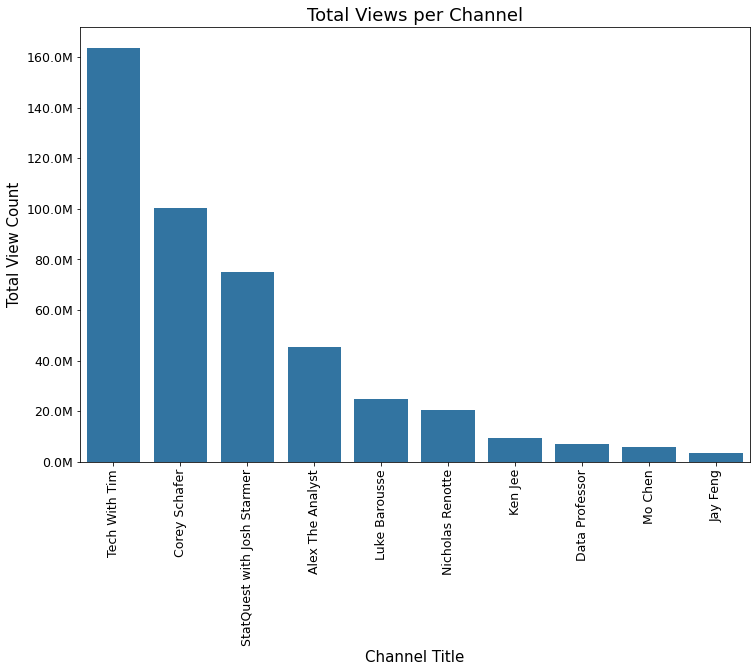

In [30]:
base_color = sb.color_palette()[0]
plt.figure(figsize = (12, 8))
ax = sb.barplot(x = 'channelTitle', y = 'viewCount', 
                data = video_df.groupby('channelTitle')['viewCount'].sum().sort_values(ascending = False).reset_index(),
               color = base_color)
ax.yaxis.set_major_formatter(formatter)

plt.title('Total Views per Channel', fontsize = 18)
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('Channel Title', fontsize = 15)
plt.ylabel('Total View Count', fontsize = 15);

#### Amongst all the channels, Tech with tom has the most views with more than 160000k views, significantly greater than the other channels. And with Jay Feng being the channel with the least number of views at 5000k

### Videos Published by Day & Month (Histogram)

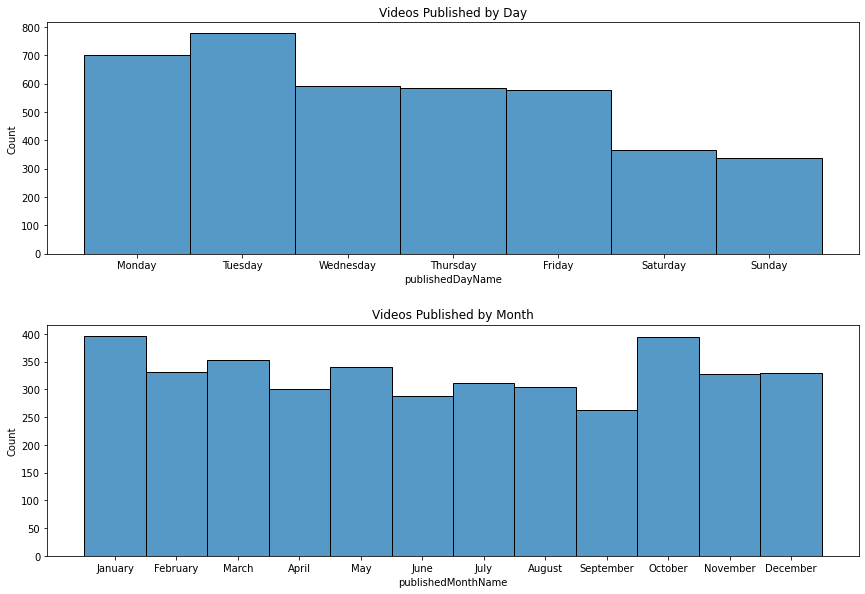

In [31]:
fig, ax = plt.subplots(2, 2, figsize = [12, 8])
fig.tight_layout(h_pad=5)

plt.subplot(2, 1, 1)
sb.histplot(data = video_df, x = "publishedDayName")
plt.title('Videos Published by Day')

plt.subplot(2, 1, 2)
sb.histplot(data = video_df, x = "publishedMonthName")
plt.title('Videos Published by Month');

#### An examination of video distribution patterns across days and months revealed interesting trends. The daily analysis showed Tuesday as the peak day for video uploads, though other weekdays maintained comparable levels. Notably, weekend uploads dropped significantly, approximately halving in number. This reduction aligns with the stock market's weekend closure.

#### Monthly distribution analysis indicated a generally steady upload rate throughout the year. However, the first and last quarters exhibited a marked increase in activity. During these periods, monthly upload counts consistently exceeded 350 videos.


### Title Length vs. Views (Scatter Plot)

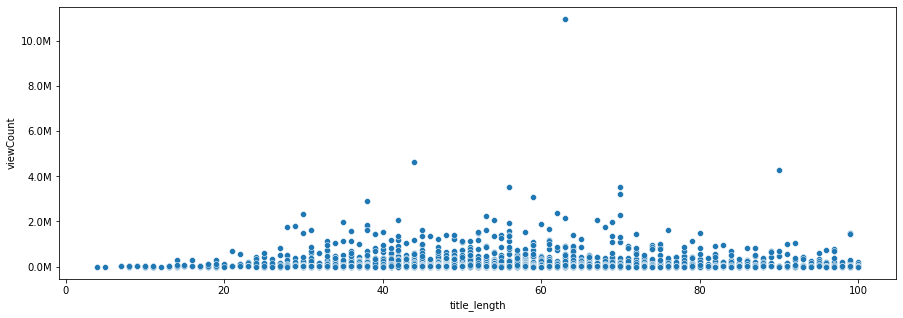

In [32]:
fig, ax = plt.subplots(figsize = [15, 5])
sb.scatterplot(data = video_df, x = 'title_length', y = 'viewCount')
ax.yaxis.set_major_formatter(formatter);

#### Analysis of the scatterplot reveals no discernible correlation between the length of video titles and their word count. However, an interesting observation emerges: the videos garnering the highest viewership tend to have titles ranging from 20 to 80 characters in length. This suggests that while title length may not directly influence word count, it could potentially impact video popularity within a specific character range.

### Video Engagement Analysis

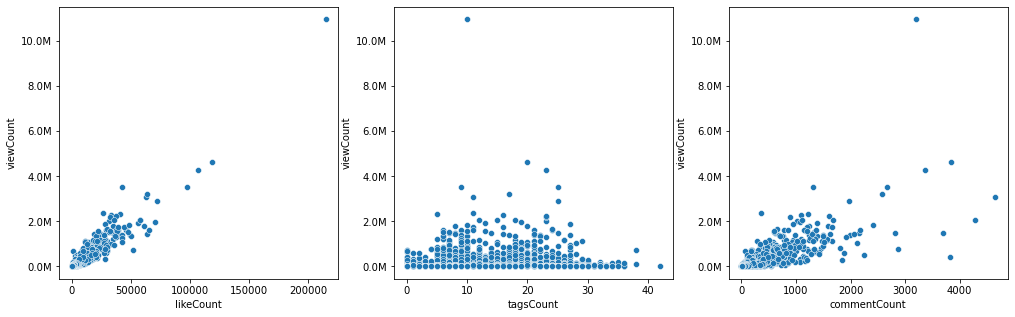

In [33]:
fig, ax = plt.subplots(1,3, figsize = [17, 5])

sb.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[0])
sb.scatterplot(data = video_df, x = 'tagsCount', y = 'viewCount', ax = ax[1])
sb.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[2])

for i in range(3):
    ax[i].yaxis.set_major_formatter(formatter);

#### The first scatterplot, comparing likeCount and viewCount, reveals a strong positive correlation. As video views increase, the number of likes tends to rise proportionally. This relationship is intuitive, though it's worth noting that high view counts don't necessarily guarantee positive reception. The absence of dislike data (due to YouTube's removal of this feature) limits our ability to fully assess viewer sentiment.

#### The second scatterplot, examining the relationship between viewCount and tagsCount, shows a distinct lack of correlation. The data points form a nearly horizontal line at the bottom of the plot, suggesting that the number of tags has little to no impact on a video's view count. Interestingly, most outliers (videos with exceptionally high view counts) fall within the 10-30 tag range.

#### The final scatterplot, comparing viewCount and commentCount, displays a positive relationship, similar to the first plot. However, the correlation appears moderate rather than strong, as the data points are more dispersed. This suggests that while higher view counts generally correspond to more comments, the relationship is less pronounced than that between views and likes.

### Video Duration

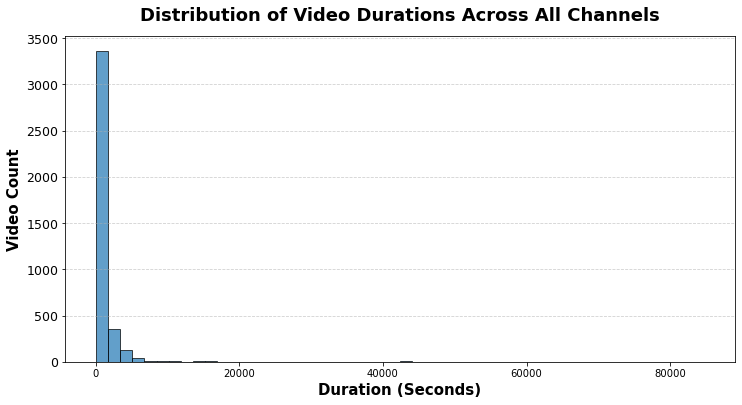

In [34]:
plt.figure(figsize=(12, 6))
plt.hist(video_df["durationSec"], bins=50, edgecolor='black', alpha=0.7)

plt.title('Distribution of Video Durations Across All Channels', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Duration (Seconds)', fontsize=15, fontweight='bold')
plt.ylabel('Video Count', fontsize=15, fontweight='bold')

plt.yticks(fontsize=12.5)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


#### The histogram plot reveals a significant left skew in the distribution of video durations across all channels. The vast majority of videos fall within the range of 0 to 5000 seconds, which translates to 0 to 1 hour, 23 minutes, and 20 seconds. This concentration of shorter videos suggests a preference for more concise content among the channels analyzed.
#### The longest video in the dataset has a duration of approximately 8,000 seconds, which is equivalent to 2 hours, 13 minutes, and 20 seconds. This outlier represents a significant departure from the typical video length and could be an exceptional case, such as a long-form interview, an in-depth analysis, or a special event coverage.

##### Key observations:

##### Typical video length: The majority of videos are relatively short, clustering in the 0-5000 second range.

##### Outliers: There are few videos extending beyond the 5000-second mark, with the longest reaching nearly 8000 seconds.

##### Content strategy: The prevalence of shorter videos might indicate a strategy to maintain viewer engagement, as briefer content is often more digestible and shareable.

#### This distribution pattern suggests that while these channels occasionally produce longer content, their primary focus is on creating videos that can be consumed within approximately 1.5 hours or less, aligning with typical attention spans and viewing habits of online audiences.

### Comments per videos for each channel

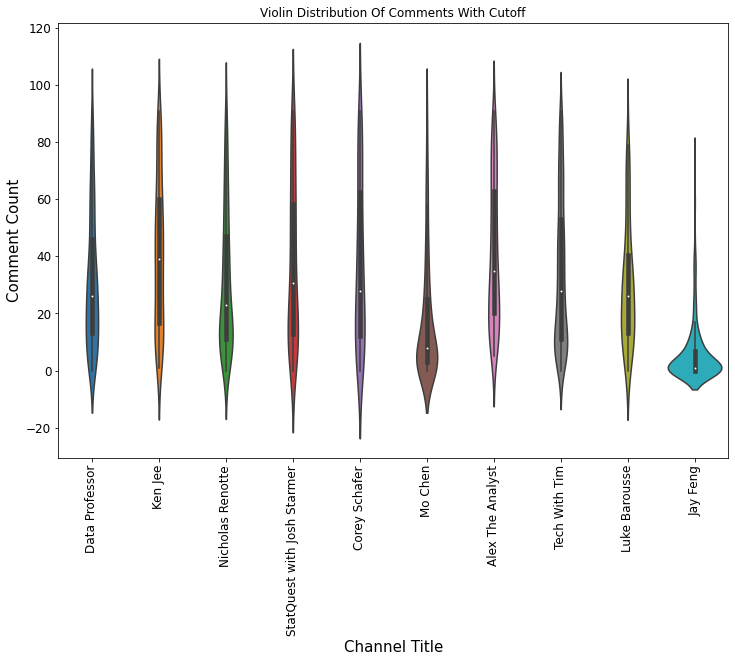

In [35]:
double_Q3 = (video_df['commentCount'].quantile(0.50))*2

fig = plt.figure(figsize = (12, 8))
ax = sb.violinplot(data = video_df[video_df.commentCount < double_Q3], x = 'channelTitle', y = 'commentCount')
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Channel Title", fontsize = 15)
plt.ylabel("Comment Count", fontsize = 15)
plt.title("Violin Distribution Of Comments With Cutoff");

#### The violin plot reveals the distribution of comment counts for various YouTube channels, with each "violin" representing a channel. The width of each violin at any point indicates the frequency of videos receiving that number of comments. 

#### Key observations include:

##### Variance in comment counts: Channels like Statquest with Josh Stammer, Ken Jee and Corey Schafer display thin, elongated violins. This shape suggests a high variance in comment counts, indicating that some videos on these channels receive significantly more comments than others. This could be due to varying content popularity or engagement levels across their videos.

##### Consistency in other channels: The wider, more symmetrical violins seen in other channels suggest a more consistent comment pattern. These channels tend to receive a similar number of comments across their videos, indicating a stable audience engagement level.

##### Interpretation of violin width: Wider sections of the violin represent a higher concentration of videos with that particular comment count. Therefore, channels with wider violins at certain points have more videos clustering around those comment counts, suggesting more predictable audience interaction.

##### Potential factors influencing patterns: It's important to note that these patterns could be influenced by various factors such as channel size, video content, upload frequency, and audience demographics. For instance, channels with narrower violins might produce more diverse content that appeals to different segments of their audience.

##### Limitations of the analysis: The cutoff applied to exclude extreme outliers helps in focusing on the typical behavior, but it's worth remembering that these outliers (highly commented videos) exist and could provide valuable insights if analyzed separately.

#### This violin plot provides a nuanced view of audience engagement across different channels, highlighting both the typical comment patterns and the variability within each channel's content. It serves as a valuable tool for understanding audience interaction and could inform content strategies for these YouTube creators.

### Box plot visualizing Distribution of Views per Video

In [36]:
def thousands(x, pos):
    return '%1.1fK' % (x*1e-3)

formatter = FuncFormatter(thousands)

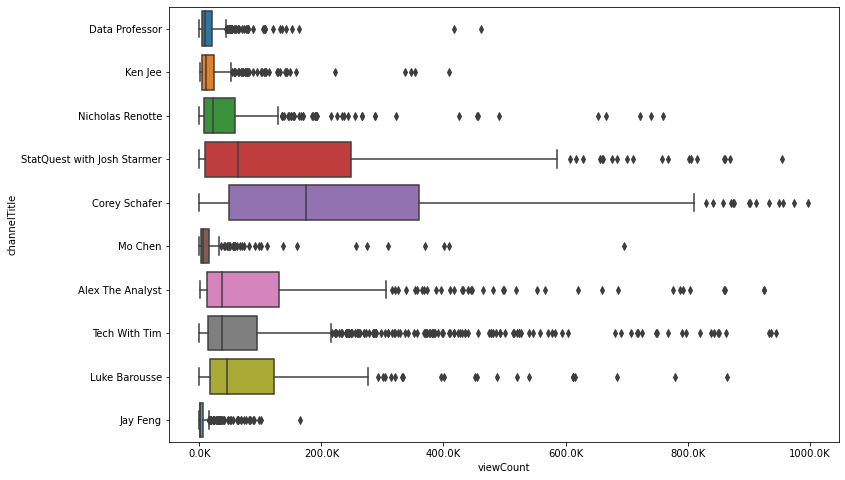

In [37]:
cutoff = 1000000

fig = plt.figure(figsize = (12, 8))
ax = sb.boxplot(data = video_df[video_df.viewCount < cutoff], y = 'channelTitle', x = 'viewCount')
ax.xaxis.set_major_formatter(formatter)

#### Top Performers
##### Corey Schafer stands out as the channel with the highest median view count, approaching 400,000 views per video. This suggests that Corey Schafer's content consistently attracts a large audience. StatQuest follows as the second-highest performer, indicating strong and steady viewership for their videos as well.

#### Mid-Range Performers
##### The majority of the other channels display significantly lower interquartile ranges (IQRs) for view counts. This indicates less variability in their typical view counts, with most of their videos receiving fewer than 100,000 views.

#### Outliers and Variability
##### Many channels, particularly Tech with Tim, exhibit numerous outliers beyond their upper quartiles. This pattern suggests that while these channels generally receive moderate view counts, they occasionally produce videos that significantly outperform their usual metrics. These outliers could represent:

##### Viral content that resonated exceptionally well with the audience
##### Videos covering trending or highly sought-after topics
##### Collaborations or special events that attracted a broader audience

### Average Views Per Upload Day & YouTube Channel

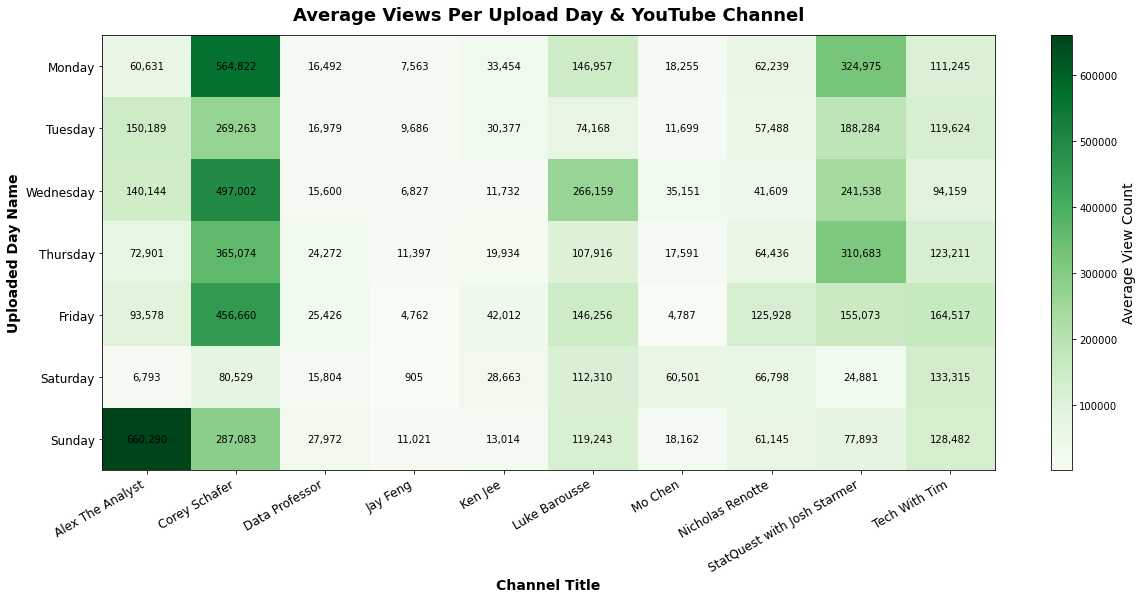

In [38]:
import numpy as np
channel_view_means = video_df.groupby(['channelTitle', 'publishedDayName'])['viewCount'].mean().reset_index(name='viewAvg')
channel_view_means = channel_view_means.pivot(columns='channelTitle', index='publishedDayName', values='viewAvg')

fig, ax = plt.subplots(figsize=(20, 8))

cmap = plt.get_cmap("Greens")
im = ax.imshow(channel_view_means, cmap=cmap, aspect='auto')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Average View Count', fontsize=14)

ax.set_xticks(np.arange(len(channel_view_means.columns)))
ax.set_yticks(np.arange(len(channel_view_means.index)))
ax.set_xticklabels(channel_view_means.columns, rotation=30, ha='right', fontsize=12)
ax.set_yticklabels(channel_view_means.index, fontsize=12)

for i in range(len(channel_view_means.index)):
    for j in range(len(channel_view_means.columns)):
        value = channel_view_means.iloc[i, j]
        if not np.isnan(value):  
            ax.text(j, i, f'{int(value):,}', ha='center', va='center', fontsize=10, color='black')

plt.title('Average Views Per Upload Day & YouTube Channel', fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Channel Title", fontsize=14, fontweight='bold')
plt.ylabel("Uploaded Day Name", fontsize=14, fontweight='bold')

plt.show()


### Channel Performance by Upload Day
#### Top Performers
##### Corey Schafer: Consistently shows the darkest shades of blue across multiple days, indicating high average view counts regardless of the upload day. This suggests a loyal and engaged audience that consistently consumes Schafer's content he demonstrates strong performance with average views never dipping below 80,000 for any upload day. This consistency indicates a stable and dedicated viewer base.
##### Alex the Analyst: Achieved the highest single-day average of 660,000 views for videos uploaded on Sundays. This outlier suggests either a particularly successful video or a trend of high-performing Sunday content.

#### Strong Contenders
##### StatQuest with Josh Stammer: Shows the second darkest shades of blue overall, though not quite matching Corey Schafer's performance. Their peak average of 324,000 views occurs for Monday uploads, indicating a potential sweet spot for their content release.
#### Lower Performers
##### Jay Feng: Consistently shows the lowest average view counts across all days. Their highest average is only 13,000 views, with most days averaging in the four-digit range. This suggests a smaller, niche audience or potential areas for improvement in content strategy or promotion.

### Content Strategy Insights

### Wordcloud for words used in Video titles

In [39]:
def plot_youtube_cloud(data):
    image = imageio.imread('cloud.png')
    
    wordcloud = WordCloud(
        background_color='white',
        mask=image,
        stopwords=stop_words,
        max_words=200,
        max_font_size=250,
        scale=3,
        random_state=1,
        color_func=lambda *args, **kwargs: "blue",
        relative_scaling=0.5
    ).generate(str(data))
    
    fig = plt.figure(figsize=(15,15), dpi=100)
    plt.axis('off')
    
    plt.imshow(wordcloud)
    plt.show()


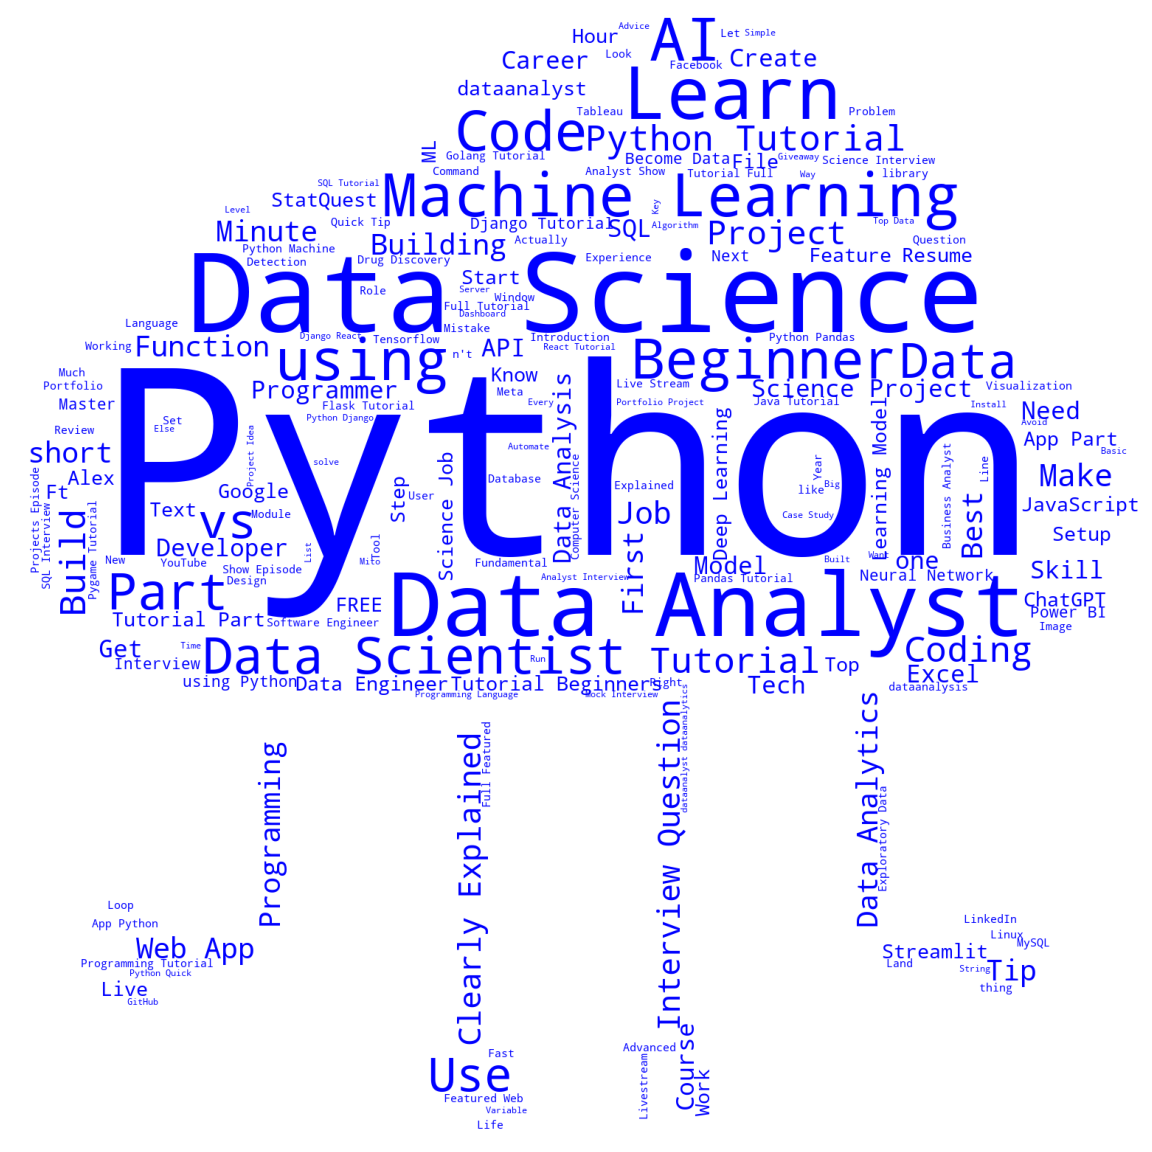

In [40]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [w for w in word_tokenize(x) if w not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)
plot_youtube_cloud(all_words_str)

#### The word cloud, shaped like the YouTube logo, offers a visual representation of the most frequently used terms in video titles. Unsurprisingly, the dominant words are closely associated with coding, statistics, and data analysis. The most prominent phrases include:
##### Python
##### Data analysis
##### Data science
##### Machine learning
##### AI
#### Upon closer inspection, we observe that the next tier of frequently occurring words primarily consists of:
##### Technologies related to data and coding
##### Job titles in the data field
##### Various programming languages
#### This word cloud effectively summarizes the main topics and themes prevalent in the analyzed YouTube content, highlighting the focus on data-centric technologies, skills, and career paths.

### Wordcloud for words used in Video Comments

In [41]:
for i in range(len(all_comments_df['comments'])):
    all_comments_df['comments'][i] = " ".join(all_comments_df['comments'][i])
all_comments_df['comments'].head()

0    hey man, sorry for this but are you looking fo...
1    I love your teaching videos because you pre-de...
2    part 2 sir............ 🔥 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 Eagerly...
3    Thanks Tutorial about generative model for dru...
4    🔑 Get AssemblyAI API key with $50 free credit ...
Name: comments, dtype: object

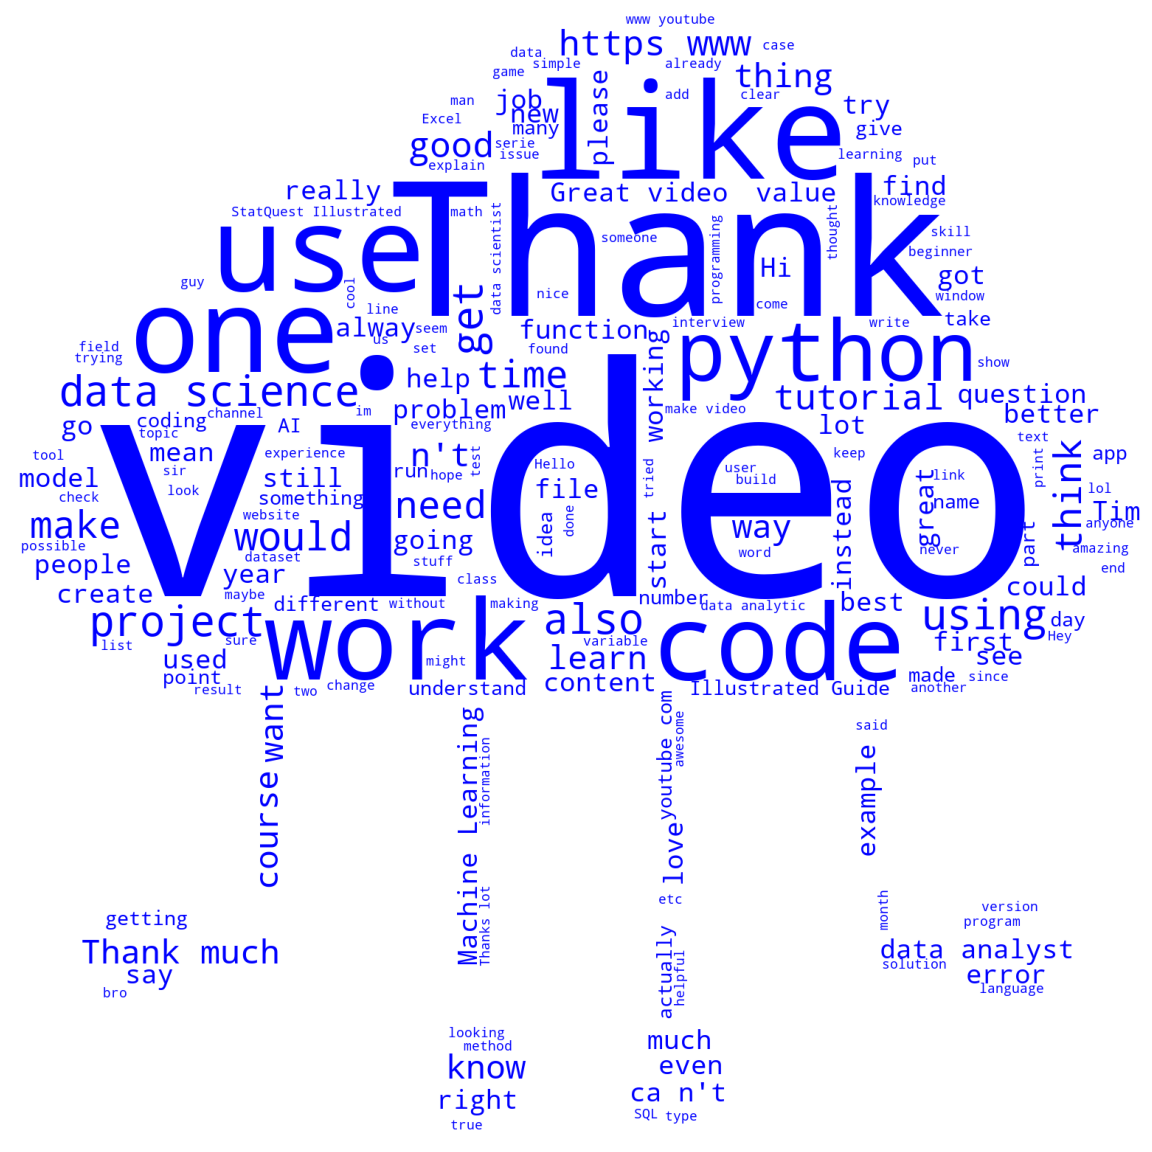

In [42]:
all_comments_df['comments_no_stopwords'] = all_comments_df['comments'].apply(lambda x: [w for w in word_tokenize(x) 
                                                                                        if w not in stop_words])
all_words = list([a for b in all_comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)
plot_youtube_cloud(all_words_str)

#### The analysis reveals both commonalities and distinctions between the most prevalent words in video titles and comments. As expected, given the subject matter, certain terms appear frequently in both areas:
##### "Python"
##### "code"
##### "Thank"
##### Various technology-related terms
#### Notably, the word cloud illustrates that Python stands out as the most discussed programming language in the comment section. This prominence in both titles and comments underscores Python's significance in the coding community and its popularity among viewers.
#### The recurring presence of technology-specific terms reflects the technical nature of the content, while the frequent appearance of "Thank" in comments suggests a positive reception from the audience. These patterns offer insights into viewer interests, content relevance, and the overall focus of coding-related videos on the platform.
#### The differences in word frequency between titles and comments likely stem from the distinct purposes they serve - titles aim to attract viewers, while comments often express gratitude, ask questions, or discuss specific aspects of the video content.
#### This linguistic analysis provides valuable information about viewer engagement, popular topics, and the effectiveness of content in meeting audience needs in the realm of coding and technology tutorials on YouTube.

### Conclusion
#### In this project, we analyzed video data from 10 different Data Analyst YouTube channels to uncover trends in video performance, engagement, and content strategies. Here’s a quick summary of our key findings:

##### Videos with more likes and comments tend to have higher view counts, with likes showing a stronger positive correlation. This suggests that the more people engage with a video, the more likely it is to be widely viewed.
##### Most videos are uploaded on weekdays, with peak uploads happening in the first three and last three months of the year.
##### YouTube videos in this dataset typically have 0-30 tags, and title lengths between 20-60 characters seem to contribute to higher view counts.
##### The most common word in both video titles and comments is "Python", highlighting its popularity in the Data Analytics community.
##### Comments are generally positive, with frequent words like "Thank" and "Video" suggesting engagement and appreciation from viewers.

#### However, it’s important to keep in mind some limitations of this analysis:

##### Our dataset contains only 3,939 videos from 9 YouTube channels, which does not fully represent all Data Analyst YouTube content.
##### We only included the first 10 comments per video, so a broader comment analysis could reveal more insights.
##### Many other factors, such as video quality, audience demographics, and algorithm influence, were not considered in this study.

#### While these findings offer valuable insights into how Data Analyst YouTube channels perform, a more extensive dataset and additional factors would be needed for a complete picture.